# Lecture 3 - Building makemore Part 2 : MLP

We implement a multilayer perceptron (MLP) character-level language model. In this video we also introduce many basics of machine learning (e.g. model training, learning rate tuning, hyperparameters, evaluation, train/dev/test splits, under/overfitting, etc.).

- [YouTube video lecture](https://youtu.be/TCH_1BHY58I)
- [Jupyter notebook files](lectures/makemore/makemore_part2_mlp.ipynb)
- [makemore Github repo](https://github.com/karpathy/makemore)

Will be following the paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

<div>
<img src="architecture.png" width="500"/>
</div>


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## The dataset

In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"Word examples : {words[:8]=}")
print(f"Total number of words : {len(words)}")

Word examples : words[:8]=['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Total number of words : 32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set("".join(words)))) # All distinct characters from all words of the dataset
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i : s for s, i in stoi.items()}
print(f"{itos=}")

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [23]:
# Build the dataset

block_size = 3 # context length : how many characters we consider as input to predict the next one (output) ?
X, Y = [], []

for i, w in enumerate(words):

    if i < 5:
        print(w)
    context = [0] * block_size # context is interchangeable with input for this task

    for ch in w + ".": # ch will be the character we want to predict (output)
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        if i < 5:
            print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix] # Update context (input) by sliding it one position to the right

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [24]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## Embedding table

In [25]:
C = torch.randn((27, 2)) # Each character will have a 2-dimensional embedding

# Get embedding of int 5 : Can either index or one-hot
assert (C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C).all().item()
print(f"{C[5]=}") # Choose indexing just cause it's easier

# Can also use list or tensors to index multiple inputs
print(f"{C[[5,6,6]]=}")
print(f"{C[torch.tensor([5,6,6])]=}")

# Can also embed multidimensional tensors simultaneously
print(f"{C[X].shape=}") # For each sample (32 samples) and each integer of the sample (3 int per sample) get the embedding (2 floats per embedding)
emb = C[X]

assert (C[X][4,2] == C[X[4, 2]]).all().item()

emb.shape, emb[30].shape, emb[30][2].shape

C[5]=tensor([-0.8797, -0.5731])
C[[5,6,6]]=tensor([[-0.8797, -0.5731],
        [-0.4223, -0.9692],
        [-0.4223, -0.9692]])
C[torch.tensor([5,6,6])]=tensor([[-0.8797, -0.5731],
        [-0.4223, -0.9692],
        [-0.4223, -0.9692]])
C[X].shape=torch.Size([228146, 3, 2])


(torch.Size([228146, 3, 2]), torch.Size([3, 2]), torch.Size([2]))

## Hidden layer

- The hidden layer will recieve as input the embeddings of all characters within the context length. We consider 3 characters as context. Each character is encoded using a 2 dimensional vector (at this moment). Therefore $3 \times 2 = 6$ total input numbers. As a result each neuron must have 6 weight parameters.
- The number of neurons within the hidden layer is a hyperparameter. We can tune it as we like. For the beginning we consider 100 neurons.
- Bias will be a vector, with 1 bias parameter per neuron. Therefore, the initial bias parameters will be 100.

**tensor.unbind(dim)** : Provides a list for all indexed versions of the tensor along the given dimension.
- For example, `emb.unbind(dim=1) == [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]`, for `emb` with shape `[32,3,2]`. 

**tensor.view(...)** : Extremely efficient operation. That is because in the memory each tensor is saved as a list `tensor.storage` and then interpeted differently using strides and shapes (This is just **the way I see it**, not an actual explanation of how it works). Using `tensor.view()` does not create a new tensor or interact with the memory. It simply changes how `tensor.storage` is interpreted.
- When using `-1` as a dimension in the view, pytorch will derive what this dimension will be. This can be done as the total number of elements must remain the same

**Efficiency** : `tensor.view`is much more efficient that `torch.cat`. That's because `torch.cat` creates a whole new tensor in the memory while `tensor.view` simply interprets the currently stored tensor in a different way

In [27]:
W1 =  torch.randn((6, 100 )) 
b1 = torch.randn(100)

#--- emb @ W1 + b1 is what we wanna do but current dimensions do not match, we have to adapt emb ---#
print(f"{emb.shape=}")
print(f"{W1.shape=}")

# The inputs we want : 32x2 (32 samples, floats per embedding) matrices with embeddings of the first, second and third word for each sample  
print(f"{(emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape)=}")

# 1st option : We concat the matrices that we want
concat_option = torch.cat(emb.unbind(dim=1), dim=1)
print(f"{concat_option.shape=}")

# 2nd option : We change the view
view_option = emb.view(-1, 6)
print(f"{view_option.shape=}")

assert (concat_option == view_option).all().item() # Concat and View option result in the tensor
assert (emb.view(emb.shape [0], 6) == emb.view(-1, 6)).all().item() # -1 Derives correctly the dimension size

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Output of first layer
print(f"{h.shape=}")

emb.shape=torch.Size([228146, 3, 2])
W1.shape=torch.Size([6, 100])
(emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape)=(torch.Size([228146, 2]), torch.Size([228146, 2]), torch.Size([228146, 2]))
concat_option.shape=torch.Size([228146, 6])
view_option.shape=torch.Size([228146, 6])
h.shape=torch.Size([228146, 100])


## Output layer


Linear layer with 27 neurons

In [28]:
W2 = torch.randn((100, 27)) # 27 Neurons of 100 weight parameters each
b2 = torch.randn(27)        # 27 bias parameters (1 per neuron )
logits = h @ W2 + b2 # Log-counts (output that we assume to represent log.counts)

## Loss

We're gonna be using negative average log-likelihood loss.

**Reasons to use F.cross_entropy in place of implementing it** 
- Memory doesn't save in-between computations.
- In general, it might have a simpler mathematic expression when computing the derivative and therefore reduce computation costs (eg. tanh).
- Works better numerically when going over very small number (eg. floating out of range). This is achieved by element-wise subtraction of the max element. This does not change the eventual probabilities due to normalization

$ x_i \rightarrow e^{x_i} \rightarrow \frac{e^{x_i}}{\sum e^{x_j}}$

$x_i + y \rightarrow e^{x_i + y} = e^{x_i}\times e^y \rightarrow \frac{e^{x_i}\times e^y}{\sum e^{x_j}\times e^y} = \frac{e^{x_i}}{\sum e^{x_j}}$

**Negative log-likelihood** : Measures how well a probability distribution predicts the observed data.

**Cross-entropy** : Cross-entropy is a measure of the difference between two probability distributions for a given set of events or outcomes.

- In this context the true probability distribution are probability vectors for filled with zeros except the probability of the index of the ground truth output which is equal to 1.

In [29]:
a = torch.tensor([1,2,-2,4,5]) - 33
a = a.exp()
a / a.sum()

tensor([1.2747e-02, 3.4649e-02, 6.3462e-04, 2.5602e-01, 6.9595e-01])

In [30]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)
loss_option1 = - prob[torch.arange(len(Y)), Y].log().mean() # NLL
loss_option2 = F.cross_entropy(logits, Y)

assert (abs(prob.sum(dim=1)-1.0) < 1e-6).all().item()
assert torch.allclose(loss_option1, loss_option2)

loss_option1, loss_option2

(tensor(15.1281), tensor(15.1281))

## Summarizing NN so far

In [31]:
# Inputs and Outputs
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [133]:
# Neural network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

In [134]:
# Parameters
parameters = [C, W1, b1, W2, b2]

# Require grad for all parameters:
for p in parameters:
    p.requires_grad = True

print(f"Total number of parameters : {sum(p.nelement() for p in parameters)}")

Total number of parameters : 3481


In [50]:
for i in range(10): 
    # Forward pass
    emb = C[X] #(32, 3, 2) : 32 samples, 3 words per sample, 2 floats per sample embedding
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss)

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data += -0.1 * p.grad
print(f"Final loss : {loss.item():.4f}")

tensor(6.7950, grad_fn=<NllLossBackward0>)
tensor(6.6766, grad_fn=<NllLossBackward0>)
tensor(6.5633, grad_fn=<NllLossBackward0>)
tensor(6.4548, grad_fn=<NllLossBackward0>)
tensor(6.3507, grad_fn=<NllLossBackward0>)
tensor(6.2506, grad_fn=<NllLossBackward0>)
tensor(6.1544, grad_fn=<NllLossBackward0>)
tensor(6.0618, grad_fn=<NllLossBackward0>)
tensor(5.9725, grad_fn=<NllLossBackward0>)
tensor(5.8863, grad_fn=<NllLossBackward0>)
Final loss : 5.8863


## Minibatches

**Minibatches** : In practise people dont perform the forward and backward pass on the whole dataset but random minibatches of it.
- Less samples so we can run more examples, in less time.
- Less samples so the quality of the gradient and therefore its direction too is not as consistent. More like an approximation. Still better to have gradient approximation and make more steps rather than having the "exact" gradient and making less steps.

- Note : At the end the loss accumulates a thickness because of these minibatches.
 

In [64]:
for _ in range(1000): 

    # Minibatch construct
    ix = torch.randint(low=0, high=X.shape[0], size=(32,)) # Minibatch of random 0 <= indices < X.shape[0] of size 32


    # Forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data += -0.1 * p.grad

print(f"Final loss (of the last minibatch): {loss.item():.4f}")

# Compute loss across whole dataset
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"Final loss (of the whole dataset): {loss.item():.4f}")

print(f"\n\n{ix.shape=}\n{X.shape=}\t{X[ix].shape=}\n{C.shape=}\t{C[X].shape=}\t{C[X[ix]].shape=}")

Final loss (of the last minibatch): 2.6310
Final loss (of the whole dataset): 2.6880


ix.shape=torch.Size([32])
X.shape=torch.Size([228146, 3])	X[ix].shape=torch.Size([32, 3])
C.shape=torch.Size([27, 2])	C[X].shape=torch.Size([228146, 3, 2])	C[X[ix]].shape=torch.Size([32, 3, 2])


## Learning rate

**Initial learning rate** : To determine a good initial learning rate you can vary the rates along the training and track both itself and the loss. Once loss starts to deteriorate (eg. increase), you can select that as the initial learning rate. Based on our plots at the very end we can conclude that a proper learning rate for this experiment would be $0.1$. 

**Decaying learning rate** : Once loss plateaus you can reduce learning rate even further and perform a few steps.

Final loss (of the last minibatch): 6.9330
Final loss (of the whole dataset): 5.5952


ix.shape=torch.Size([32])
X.shape=torch.Size([228146, 3])	X[ix].shape=torch.Size([32, 3])
C.shape=torch.Size([27, 2])	C[X].shape=torch.Size([228146, 3, 2])	C[X[ix]].shape=torch.Size([32, 3, 2])


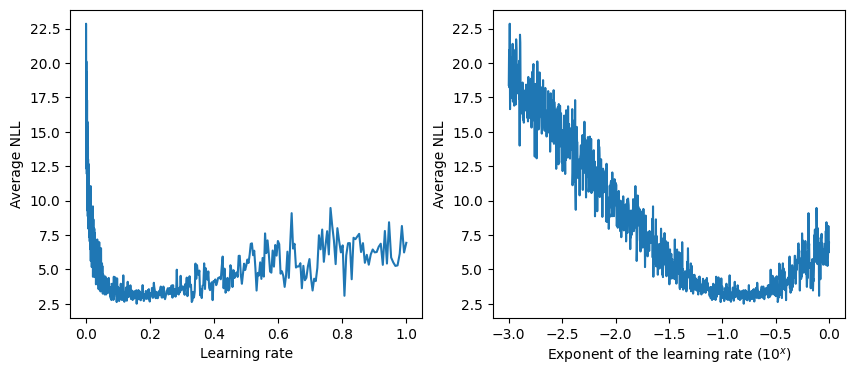

In [87]:
lre = torch.linspace(start=-3, end=0, steps=1000) # Makes n=steps numbers between start and end spaced linearly
lrs = 10 ** lre # Simple transformation to space samples exponentially

lri = []
lrei = []
lossi = []

for i in range(1000): 

    # Minibatch construct
    ix = torch.randint(low=0, high=X.shape[0], size=(32,)) 


    # Forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = lrs[i] # Varying the learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    lri.append(lr) # learning rate
    lrei.append(lre[i])
    lossi.append(loss.item()) # loss

print(f"Final loss (of the last minibatch): {loss.item():.4f}")

# Compute loss across whole dataset
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"Final loss (of the whole dataset): {loss.item():.4f}")

print(f"\n\n{ix.shape=}\n{X.shape=}\t{X[ix].shape=}\n{C.shape=}\t{C[X].shape=}\t{C[X[ix]].shape=}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(lri, lossi)
ax1.set_xlabel("Learning rate")
ax1.set_ylabel("Average NLL")
ax2.plot(lrei, lossi)
ax2.set_xlabel("Exponent of the learning rate ($10^x$)")
ax2.set_ylabel("Average NLL")
plt.show()

Final loss (of the last minibatch): 2.3348
Final loss (of the whole dataset): 2.2988


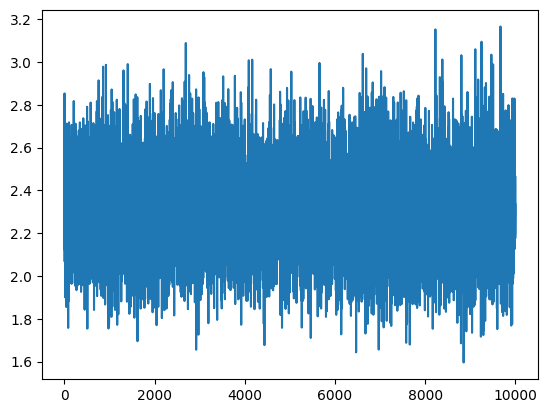

In [114]:
# Training with selected learning rate : Starting with 0.1 and once loss plateaus switch to 0.01
lossi = []
for i in range(10000): 

    # Minibatch construct
    ix = torch.randint(low=0, high=X.shape[0], size=(32,)) 

    # Forward pass
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # Track stats
    lossi.append(loss.item()) # loss

print(f"Final loss (of the last minibatch): {loss.item():.4f}")

# Compute loss across whole dataset
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f"Final loss (of the whole dataset): {loss.item():.4f}")

plt.plot(range(len(lossi)), lossi)
plt.show()

## Splitting the dataset

**Train split** : Used to train the parameters of the model (~80%).

**Validation split** : Used to train the hyperparameters of the model (~10%).

**Test split** : Used to evaluate the performance of the model at the end (~10%).

- Note : Training loss $\approx$ Validation loss means we haven't overfitted but probably underfitted.

In [117]:
# build the dataset

def build_dataset(words, block_size=3):
  # Exact same thing as before
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [135]:
# Training on the splits
lossi = []
for i in range(10000): 

    # Minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(32,)) 

    # Forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # Track stats
    lossi.append(loss.item()) # loss

# Training loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Training loss: {loss.item():.4f}")

# Validation
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Validation loss: {loss.item():.4f}")

Training loss: 2.5780
Validation loss: 2.5708


## Experiment 1 : Larger hidden layer

Total number of parameters : 10281
Training loss: 2.4399
Validation loss: 2.4347


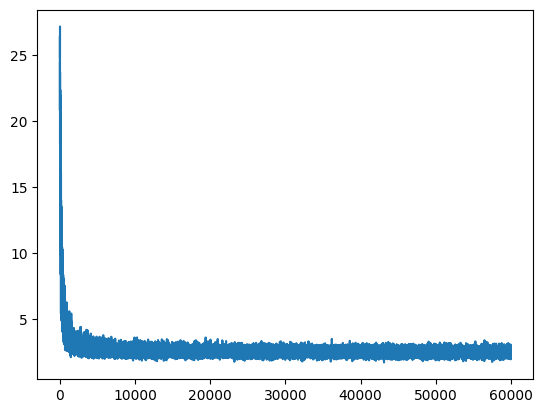

In [132]:
# Neural network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g) # Increasing the hidden layer's neurons
b1 = torch.randn(300, generator=g) # Increasing the hidden layer's neurons
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

# Require grad for all parameters:
for p in parameters:
    p.requires_grad = True

print(f"Total number of parameters : {sum(p.nelement() for p in parameters)}")

# Training on the splits
lossi = []
stepi = []
for i in range(60000): 

    # Minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(32,)) 

    # Forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backwardpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # Track stats
    lossi.append(loss.item()) 
    stepi.append(i) # step

# Training loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Training loss: {loss.item():.4f}")

# Validation
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Validation loss: {loss.item():.4f}")

plt.plot(stepi, lossi)
plt.show()

## Visualizing the embeddings

The parameters of the embeddings are trained too! As a result we can see some clustering when visualizing the embeddings in the two dimensional space (which is also their actual space).

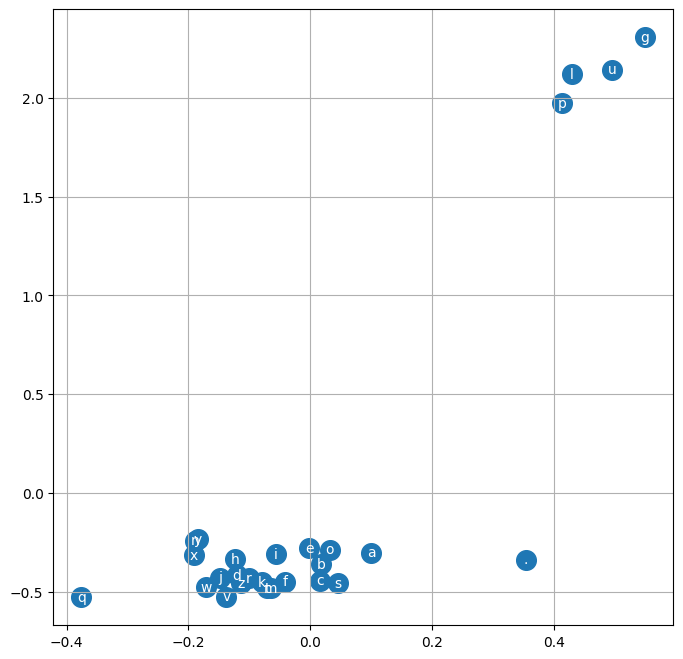

In [139]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

## Experiment 2 : Embeddings

Idea : It's possible that even though we have increased our hidden layer's size, the network still bottlenecks before it even gets there because of the embeddings size.

**Log-loss** : When loss automatically drops we can use log-loss to squash it out.

- Note : With our optimizations (increased hidden layer and increased embedding size) we can see that the performance has not only improved but also the performance between the training and validation set diverges more and more, a sign that we are no longer underfitting.

Total number of parameters : 11897
Training loss: 2.1924
Validation loss: 2.2190


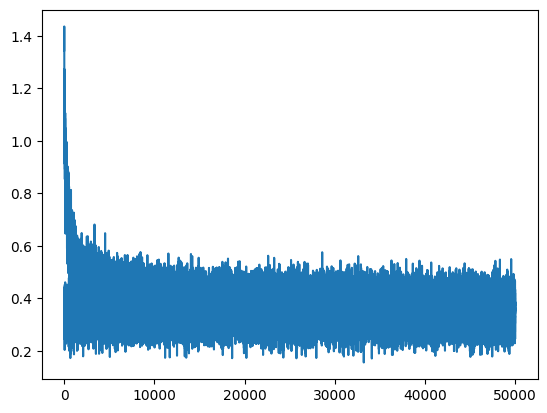

In [144]:
# Neural network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)  # Embedding in 10-size dimension instead of 2
W1 = torch.randn((30, 200), generator=g) # Input is 3 bigrams encoded in 10-size dimension -> 3 * 10 = 30 weight parameters per neuron
b1 = torch.randn(200, generator=g) 
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

# Require grad for all parameters:
for p in parameters:
    p.requires_grad = True

print(f"Total number of parameters : {sum(p.nelement() for p in parameters)}")

# Training on the splits
lossi = []
stepi = []

for lr in [0.1, 0.01]:
    for i in range(50000): 

        # Minibatch construct
        ix = torch.randint(low=0, high=Xtr.shape[0], size=(32,)) 

        # Forward pass
        emb = C[Xtr[ix]] 
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])

        # Backwardpass
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update the parameters
        for p in parameters:
            p.data += -lr * p.grad
        
        # Track stats
        lossi.append(loss.log10().item()) # Plotting log loss instead
        stepi.append(i) # step

# Training loss
emb = C[Xtr] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"Training loss: {loss.item():.4f}")

# Validation
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"Validation loss: {loss.item():.4f}")

plt.plot(stepi, lossi)
plt.show()

## Ideas to improve the model even more 

- Increase the number of neurons in the hidden layer. 
- Increase the dimensionality of the embedding space. 
- Increase the number of characters (input/context) that we are feeding to the model (from 3 to 4,5,...).
- Optimization details (number of steps, learning rate, learning rate decay, batch size,)

## Sampling from the model

In [145]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eria.
kayah.
seel.
nihah.
lorethan.
endra.
graderedielin.
shi.
jenleigh.
estanar.
elleimahkelin.
shubergiag.
jest.
jairetherrenterofius.
kyldi.
jamyleyekshiah.
myshayde.
hil.
salyansun.
zakhylen.
